## Import

In [ ]:
# ! pip install ta

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import os
import datetime

import mplfinance as mpf
from decimal import Decimal
import ta

## Load

In [2]:
with open('../dataset/kospi200_preprocessed.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,date,time,open,high,low,close,prevClose,vol
2010-02-16 09:01:00,20100216,901,207.55,207.65,207.50,207.60,207.5,3985.0
2010-02-16 09:02:00,20100216,902,207.60,207.65,207.25,207.55,207.5,5095.0
2010-02-16 09:03:00,20100216,903,207.55,207.80,207.50,207.60,207.5,2175.0
2010-02-16 09:04:00,20100216,904,207.55,207.85,207.55,207.80,207.5,1301.0
2010-02-16 09:05:00,20100216,905,207.80,208.15,207.80,208.05,207.5,3870.0


In [4]:
# time - date 날리기 
df.drop(['date', 'time'], axis=1, inplace=True)
df.tail(5)

,open,high,low,close,prevClose,vol
2020-04-03 15:32:00,231.40,231.40,231.30,231.35,231.65,876.0
2020-04-03 15:33:00,231.35,231.40,231.30,231.35,231.65,586.0
2020-04-03 15:34:00,231.40,231.40,231.30,231.30,231.65,210.0
2020-04-03 15:35:00,231.30,231.50,231.30,231.40,231.65,932.0
2020-04-03 15:45:00,231.65,231.65,231.65,231.65,231.65,6748.0


In [5]:
# vol -> volumn으로 수정 (캔들 차트를 이용하기 위해서)
df.columns = ['Open', 'High', 'Low', 'Close', 'PrevClose', 'Volumn']
df.head(1)

,Open,High,Low,Close,PrevClose,Volumn
2010-02-16 09:01:00,207.55,207.65,207.5,207.6,207.5,3985.0


### NA 처리 

#### 수집이 이상하게 된 날 

In [8]:
df[df.index.date == datetime.date(2010,7,16)].tail(5)

,Open,High,Low,Close,PrevClose,Volumn
2010-07-16 15:02:00,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-16 15:03:00,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-16 15:04:00,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-16 15:05:00,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-16 15:15:00,227.05,229.95,227.05,229.1,229.65,3901.0


이 데이터는 장에 문제가 있지 않았음에도 제대로 수집되지 않은 데이터다. 마감 시간에만 데이터가 수집되었고, 나는 이 날짜의 데이터를 삭제했다. 

In [6]:
df = df[df.index.date != datetime.date(2010,7,16)]

In [61]:
df[df.index.date == datetime.date(2010,7,16)] # 정상적으로 데이터가 제거됐음을 확인한다. 

,Open,High,Low,Close,PrevClose,Volumn


#### 보간법 : ffill

보간법의 방식은 다양하다. linear처럼 결측 이전과 이후의 데이터를 이용하는 경우도 있고, ffill처럼 이전의 데이터를 받아 사용하는 경우가 있다.  
나는 "마지막 가격이 유지된다"는 가정을 기반으로  선물 데이터를 전처리했다. 이는 코로나 시국에 있었던 서킷브레이커 상황(2020-03-13 10시 44분, 2020-03-19 12시 7분)을 원만하게 처리하고, 수집된 데이터의 정보를 보수적이게 다루기 위함이다. 

서킷 브레이커에서 상황은 고민 중이라 일단 걍 삭제

In [7]:
df[(df.index.date == datetime.date(2020,3,13)) | (df.index.date == datetime.date(2020,3,19))].isna().sum()

Open         58
High         58
Low          58
Close        58
PrevClose    58
Volumn       58
dtype: int64

In [8]:
df = df[(df.index.date != datetime.date(2020,3,13)) & (df.index.date != datetime.date(2020,3,19))].ffill()

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
PrevClose    0
Volumn       0
dtype: int64

### 스케일링 

선물 데이터는 데이터의 비정상성이 강하기 때문에 전역으로 범위를 잡고 스케일링하는 것이 효과적이지 않다고 판단했다.  
물론 이후에는 좀 더 세분화된 모듈화가 필요하지만, 지금 단계에서는 필요한 df를 여기다가 정의해서 사용한다.  

🚨🚨 **이후 backtest를 고려해야 하기 때문에, 복구하는 모듈까지 같이 생성해야 한다.**  
-> 스케일러 자체를 class로 짜자 

사용한 스케일러 종류  
> 출처 : https://velog.io/@jiazzang/데이터-전처리-데이터-스케일링StandardScaler-MinMaxScaler-Robust

In [9]:
# 년도 기준 스케일링 
# ------------------
## 표준화 
z_scaled_by_year = df.groupby(df.index.year)['Close'].transform(lambda x: (x - x.mean()) / x.std()).to_frame()
## min-max 스케일링
mm_scaled_by_year = df.groupby(df.index.year)['Close'].transform(lambda x: (x - x.min()) / (x.max() - x.min())).to_frame()
## Robust : 이상치에 둔해지는 경향 
r_scaled_by_year = df.groupby(df.index.year)['Close'].transform(lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25))).to_frame()

### timestep 조정

분당 지표를 시봉 - 일봉 - 주봉 - 월봉 으로 바꿀 수 있는 함수 & 결과물이다.  


In [ ]:
def down_sampling(df, interval:str):
    "'min'=분, 'h'=시, 'D'=일, 'W'=주,  'ME'=월, 'YE'=년"
    if interval not in ['t', 'h', 'd', 'w', 'm', 'min', 'y','YE', 'T', 'H', 'D', 'W', 'M', 'Y']:
        ValueError("")
    
    new_df = pd.DataFrame()
    new_df['open'] = df['open'].resample(interval).first()
    new_df['high'] = df['high'].resample(interval).max()
    new_df['low'] = df['low'].resample(interval).min()
    new_df['close'] = df['close'].resample(interval).last()
    new_df['prevClose'] = df['prevClose'].resample(interval).first()
    new_df['vol'] = df['vol'].resample(interval).sum()
    new_df = new_df[~new_df['open'].isna()]
    return new_df

In [ ]:
h_df = down_sampling(df, 'h')
d_df = down_sampling(df, 'D')
w_df = down_sampling(df, 'W')
m_df = down_sampling(df, 'ME')
y_df = down_sampling(df, 'YE')

# EDA

## 연도별 추이

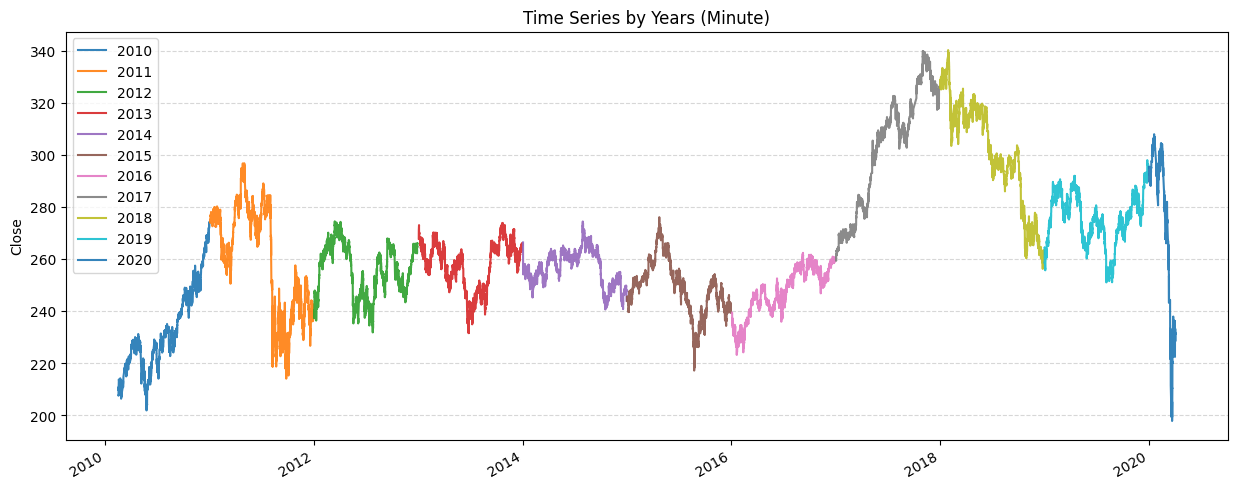

In [105]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in df.groupby(df.index.year):
    group[['Close']].plot(ax=ax, alpha=0.9)

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Minute)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

## 월별 종가 변동 

- 전체 데이터 

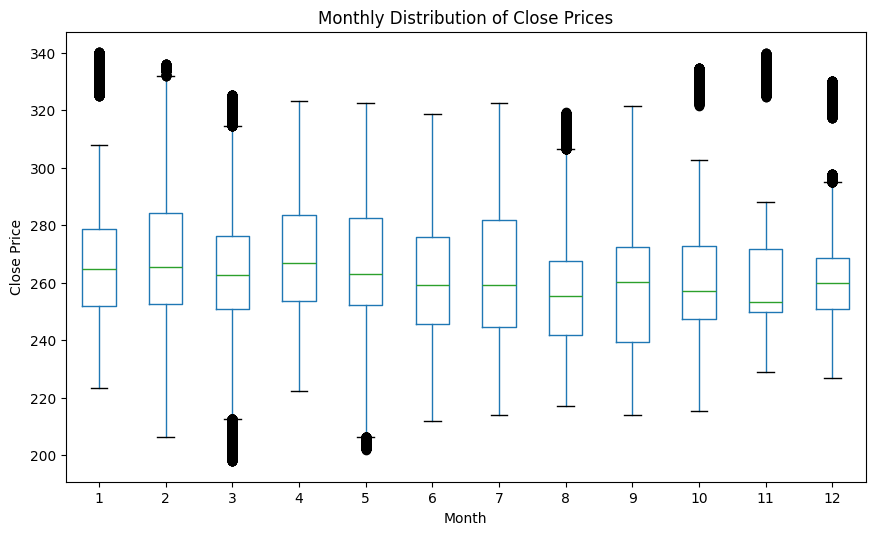

In [72]:
df['Month'] = df.index.month
df.boxplot(column='Close', by='Month', figsize=(10, 6))
plt.title('Monthly Distribution of Close Prices')
plt.suptitle('')  
plt.grid(False)
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()

#### 모듈 : plot_mycp

In [ ]:
def plot_mycp(df):
    """
    mycp : Monthly Yearly Close Price Plot
    shape : (4,3)
    """
    # 서브플롯 설정
    _, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), sharey=True)
    axes = axes.flatten()  # 1차원으로 만들어서 인덱싱 쉽게

    for month in range(1, 13):
        # 해당 월 데이터 필터링
        monthly_data = df[df.index.month == month]

        # 연도별로 'Close' 값 모으기
        grouped = [group['Close'] for _, group in monthly_data.groupby(monthly_data.index.year)]

        # x축 레이블용 연도 목록
        years = sorted(monthly_data.index.year.unique())

        # 박스플롯 그리기
        axes[month - 1].boxplot(grouped, tick_labels=years)
        axes[month - 1].set_title(f'{month}')
        axes[month - 1].set_xlabel('Year')
        if month in [1, 5, 9]:
            axes[month - 1].set_ylabel('Close Price')

    plt.suptitle('Monthly Yearly Close Price Plot', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

original


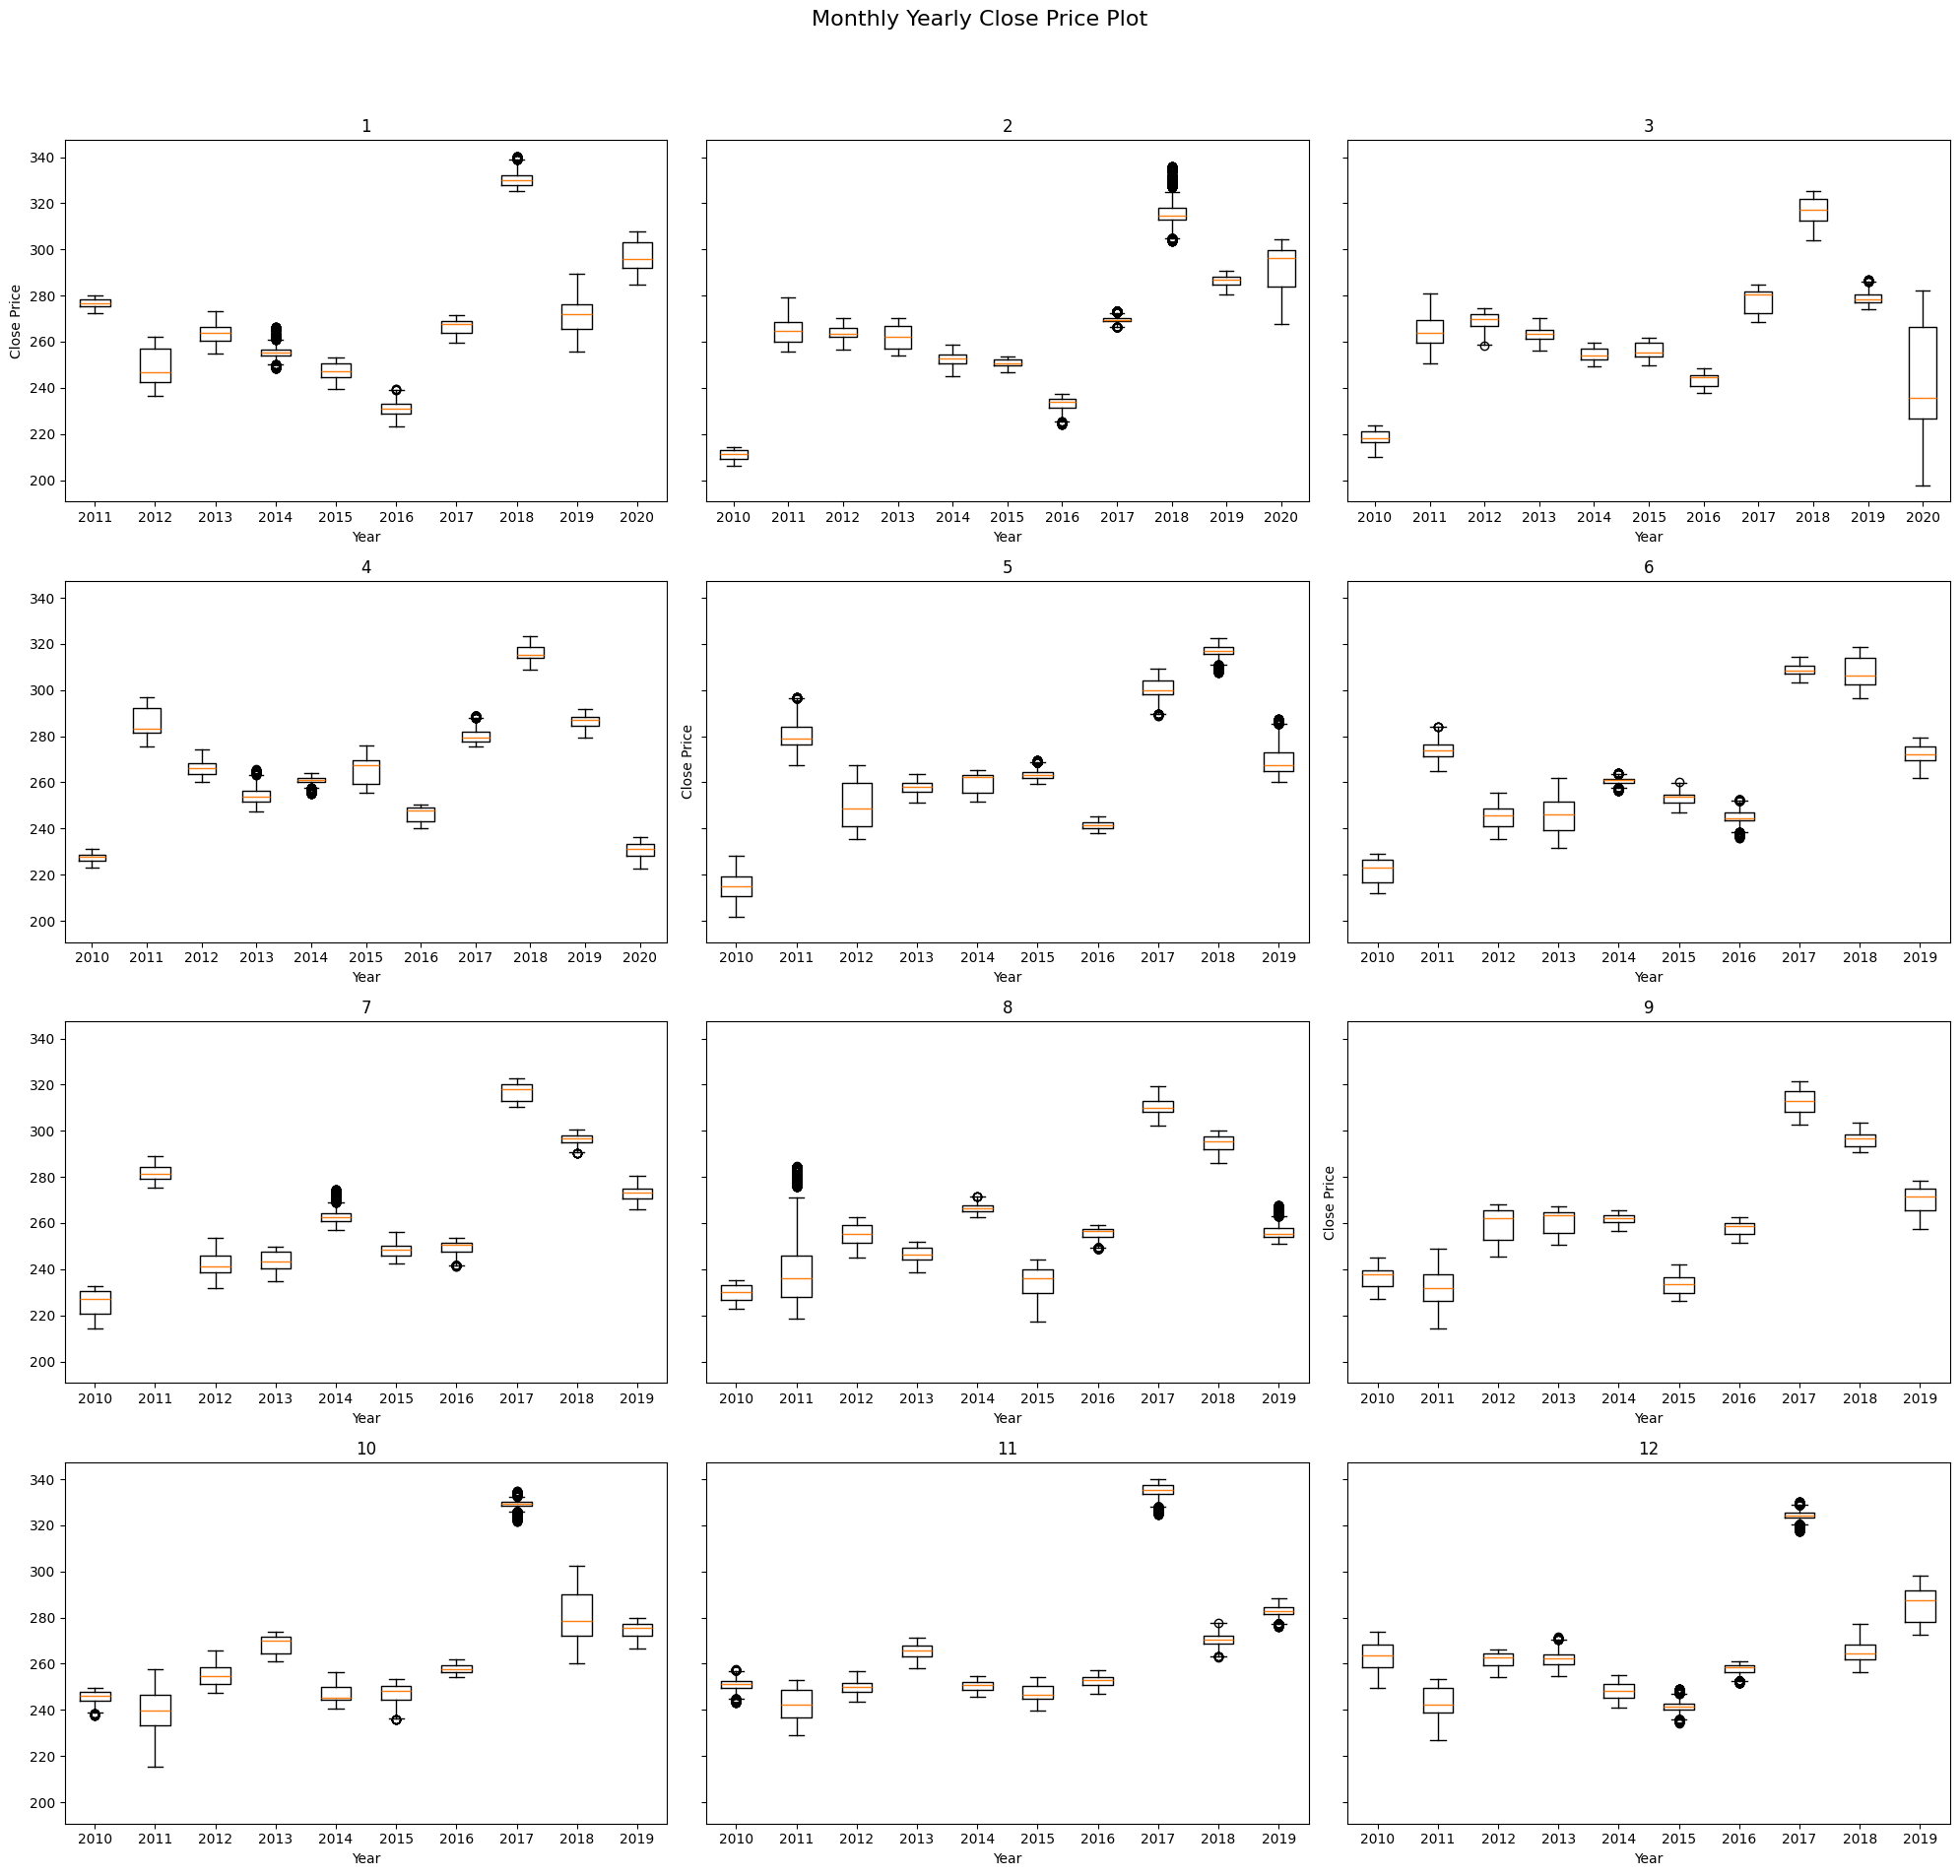

z_scaled_by_year


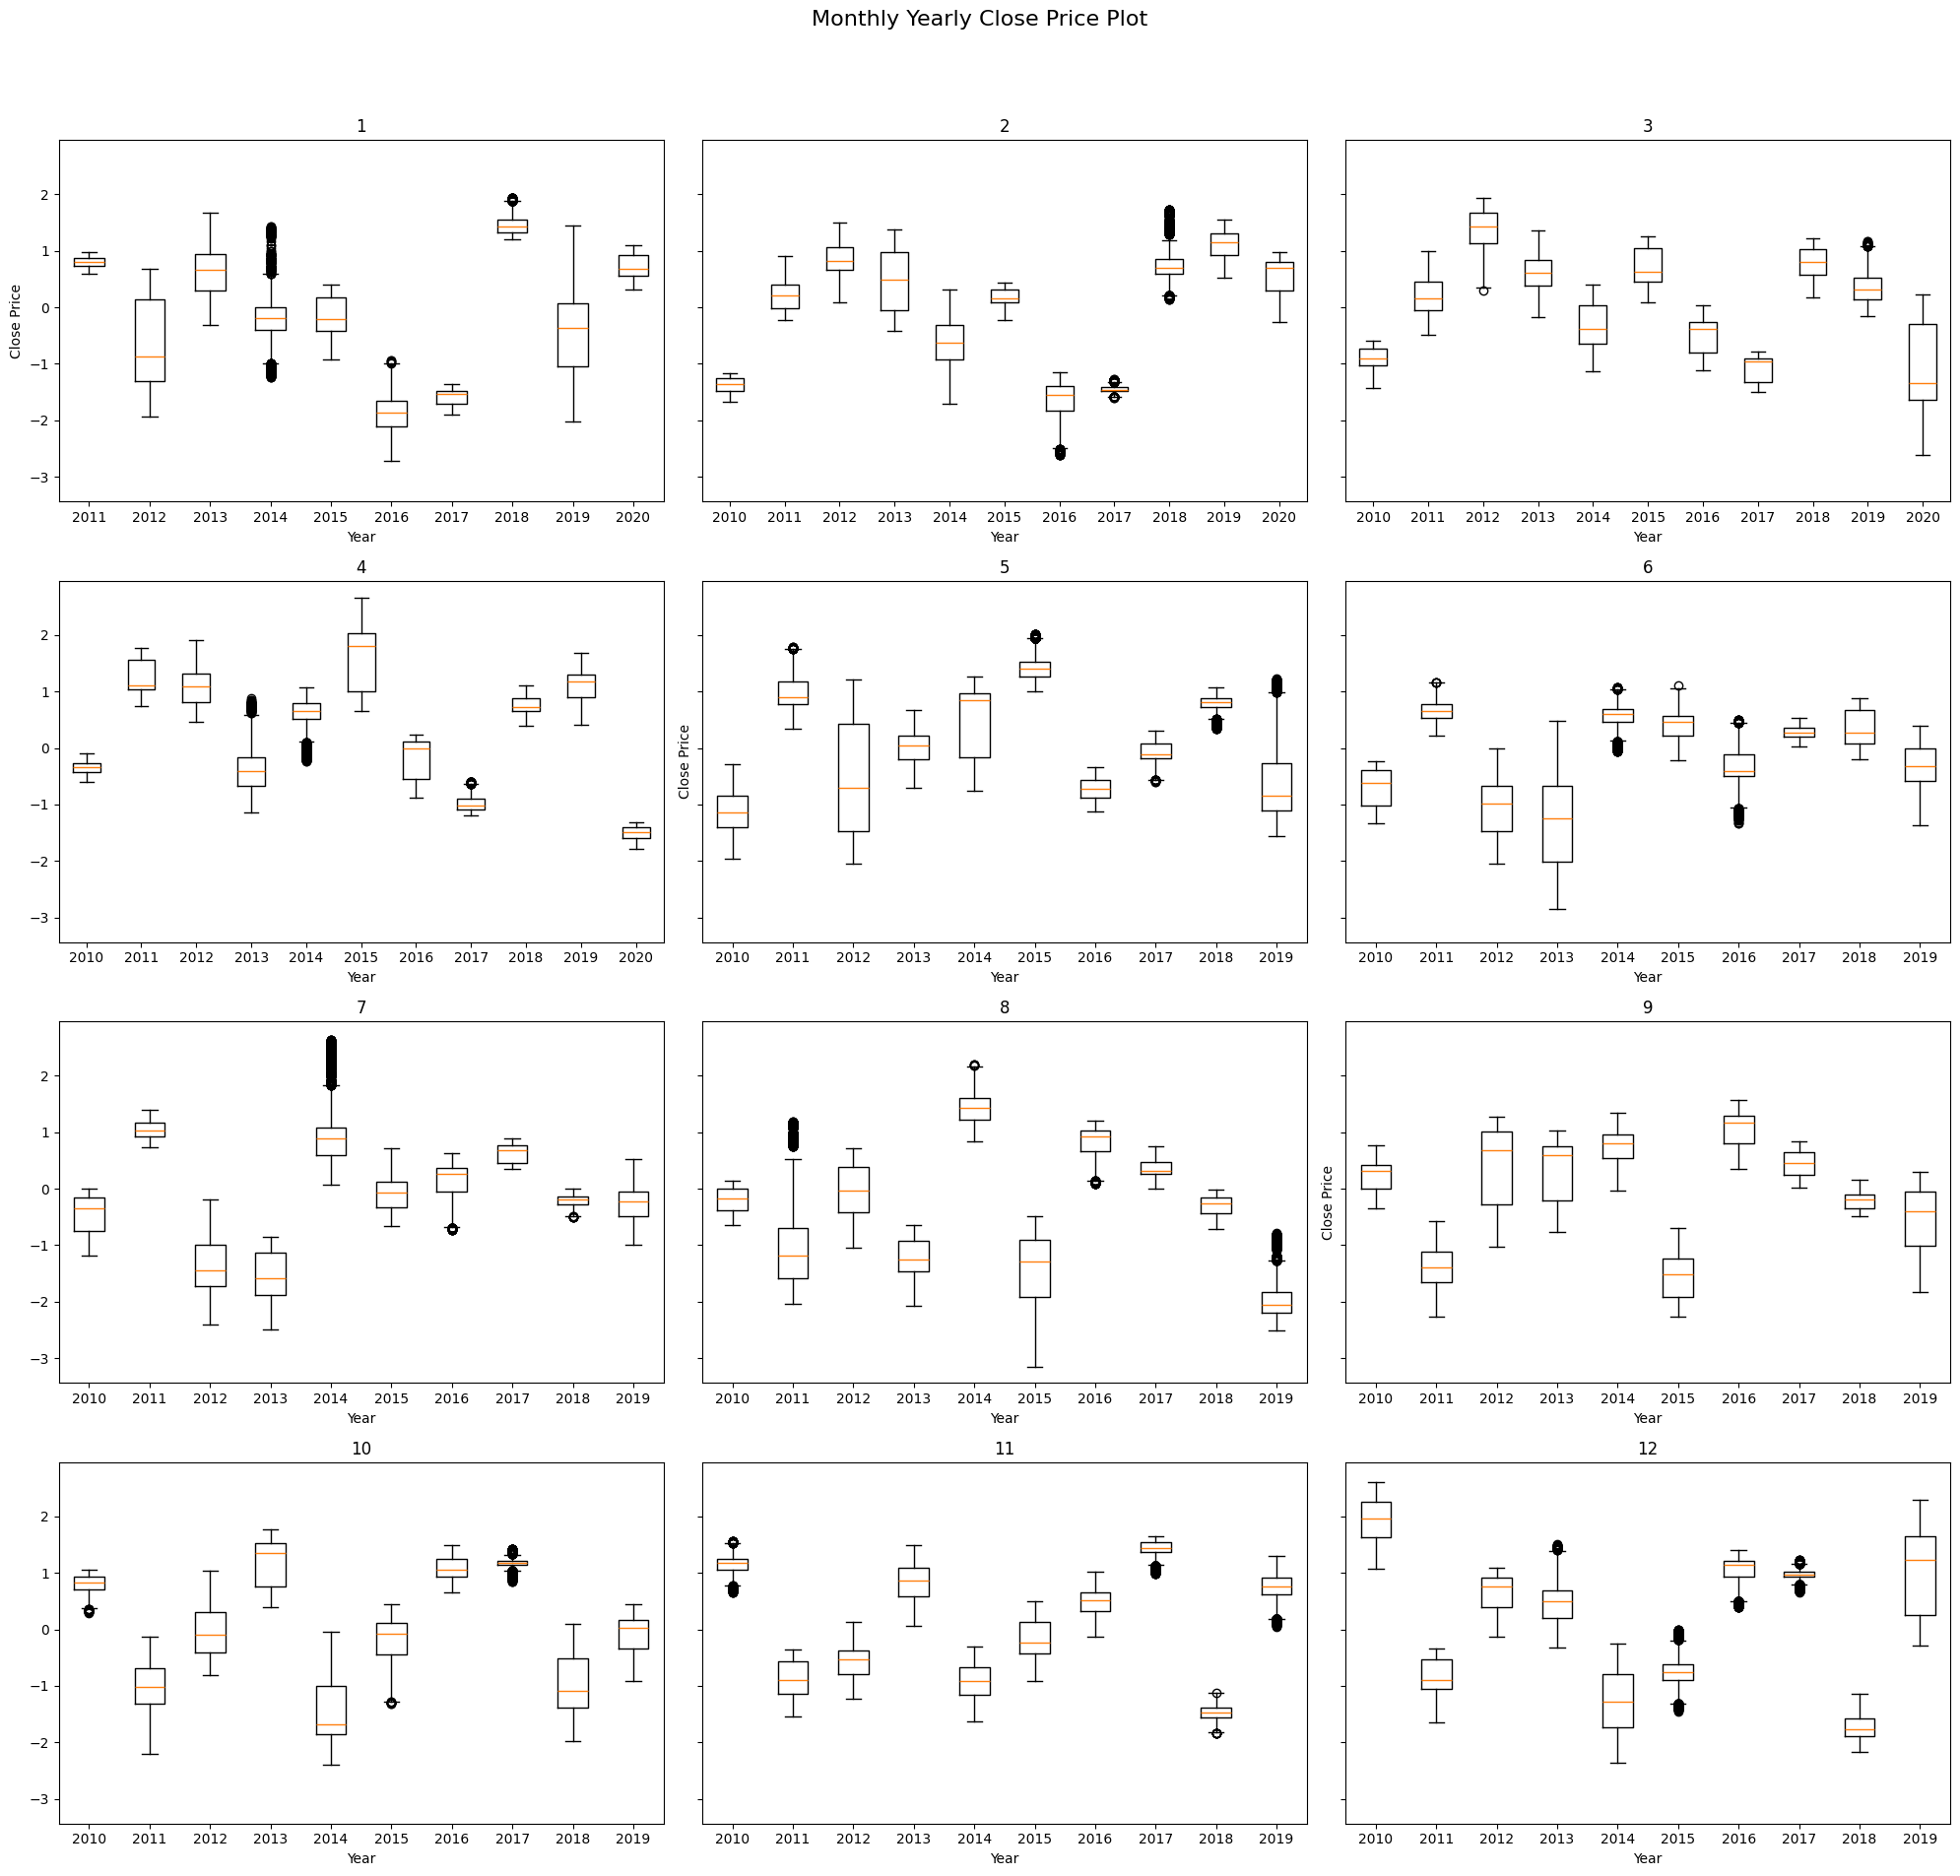

mm_scaled_by_year


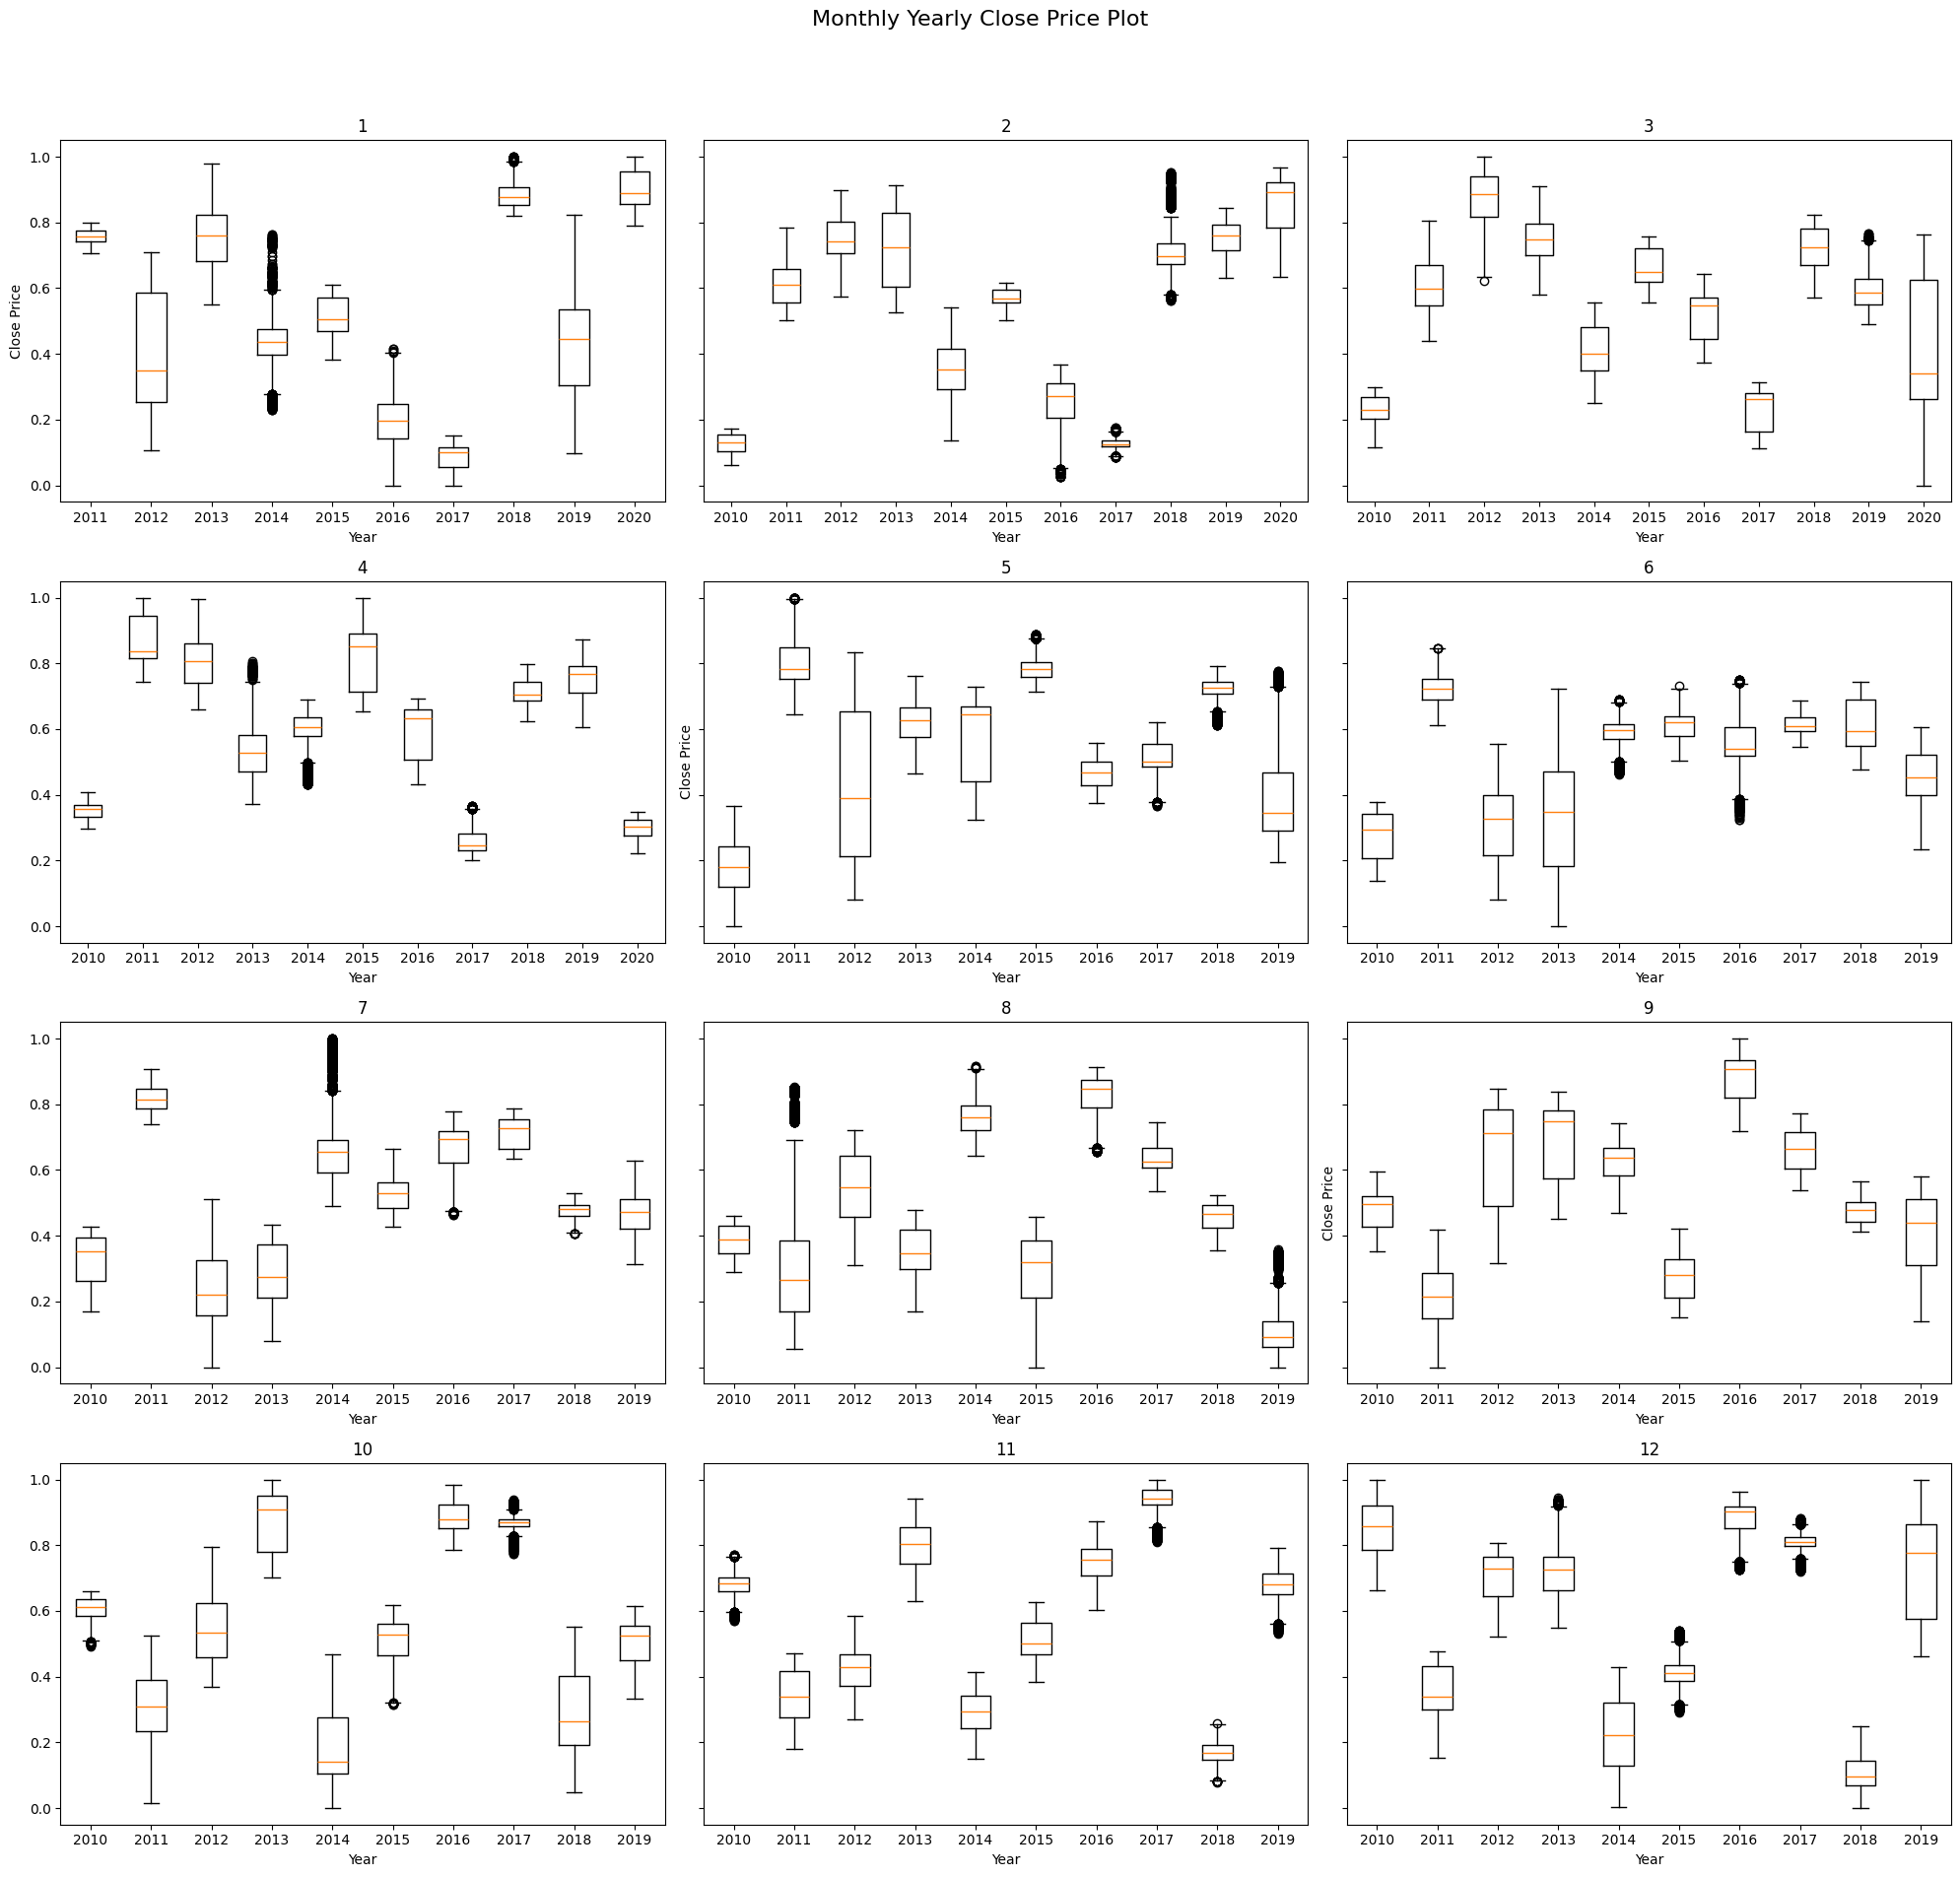

r_scaled_by_year


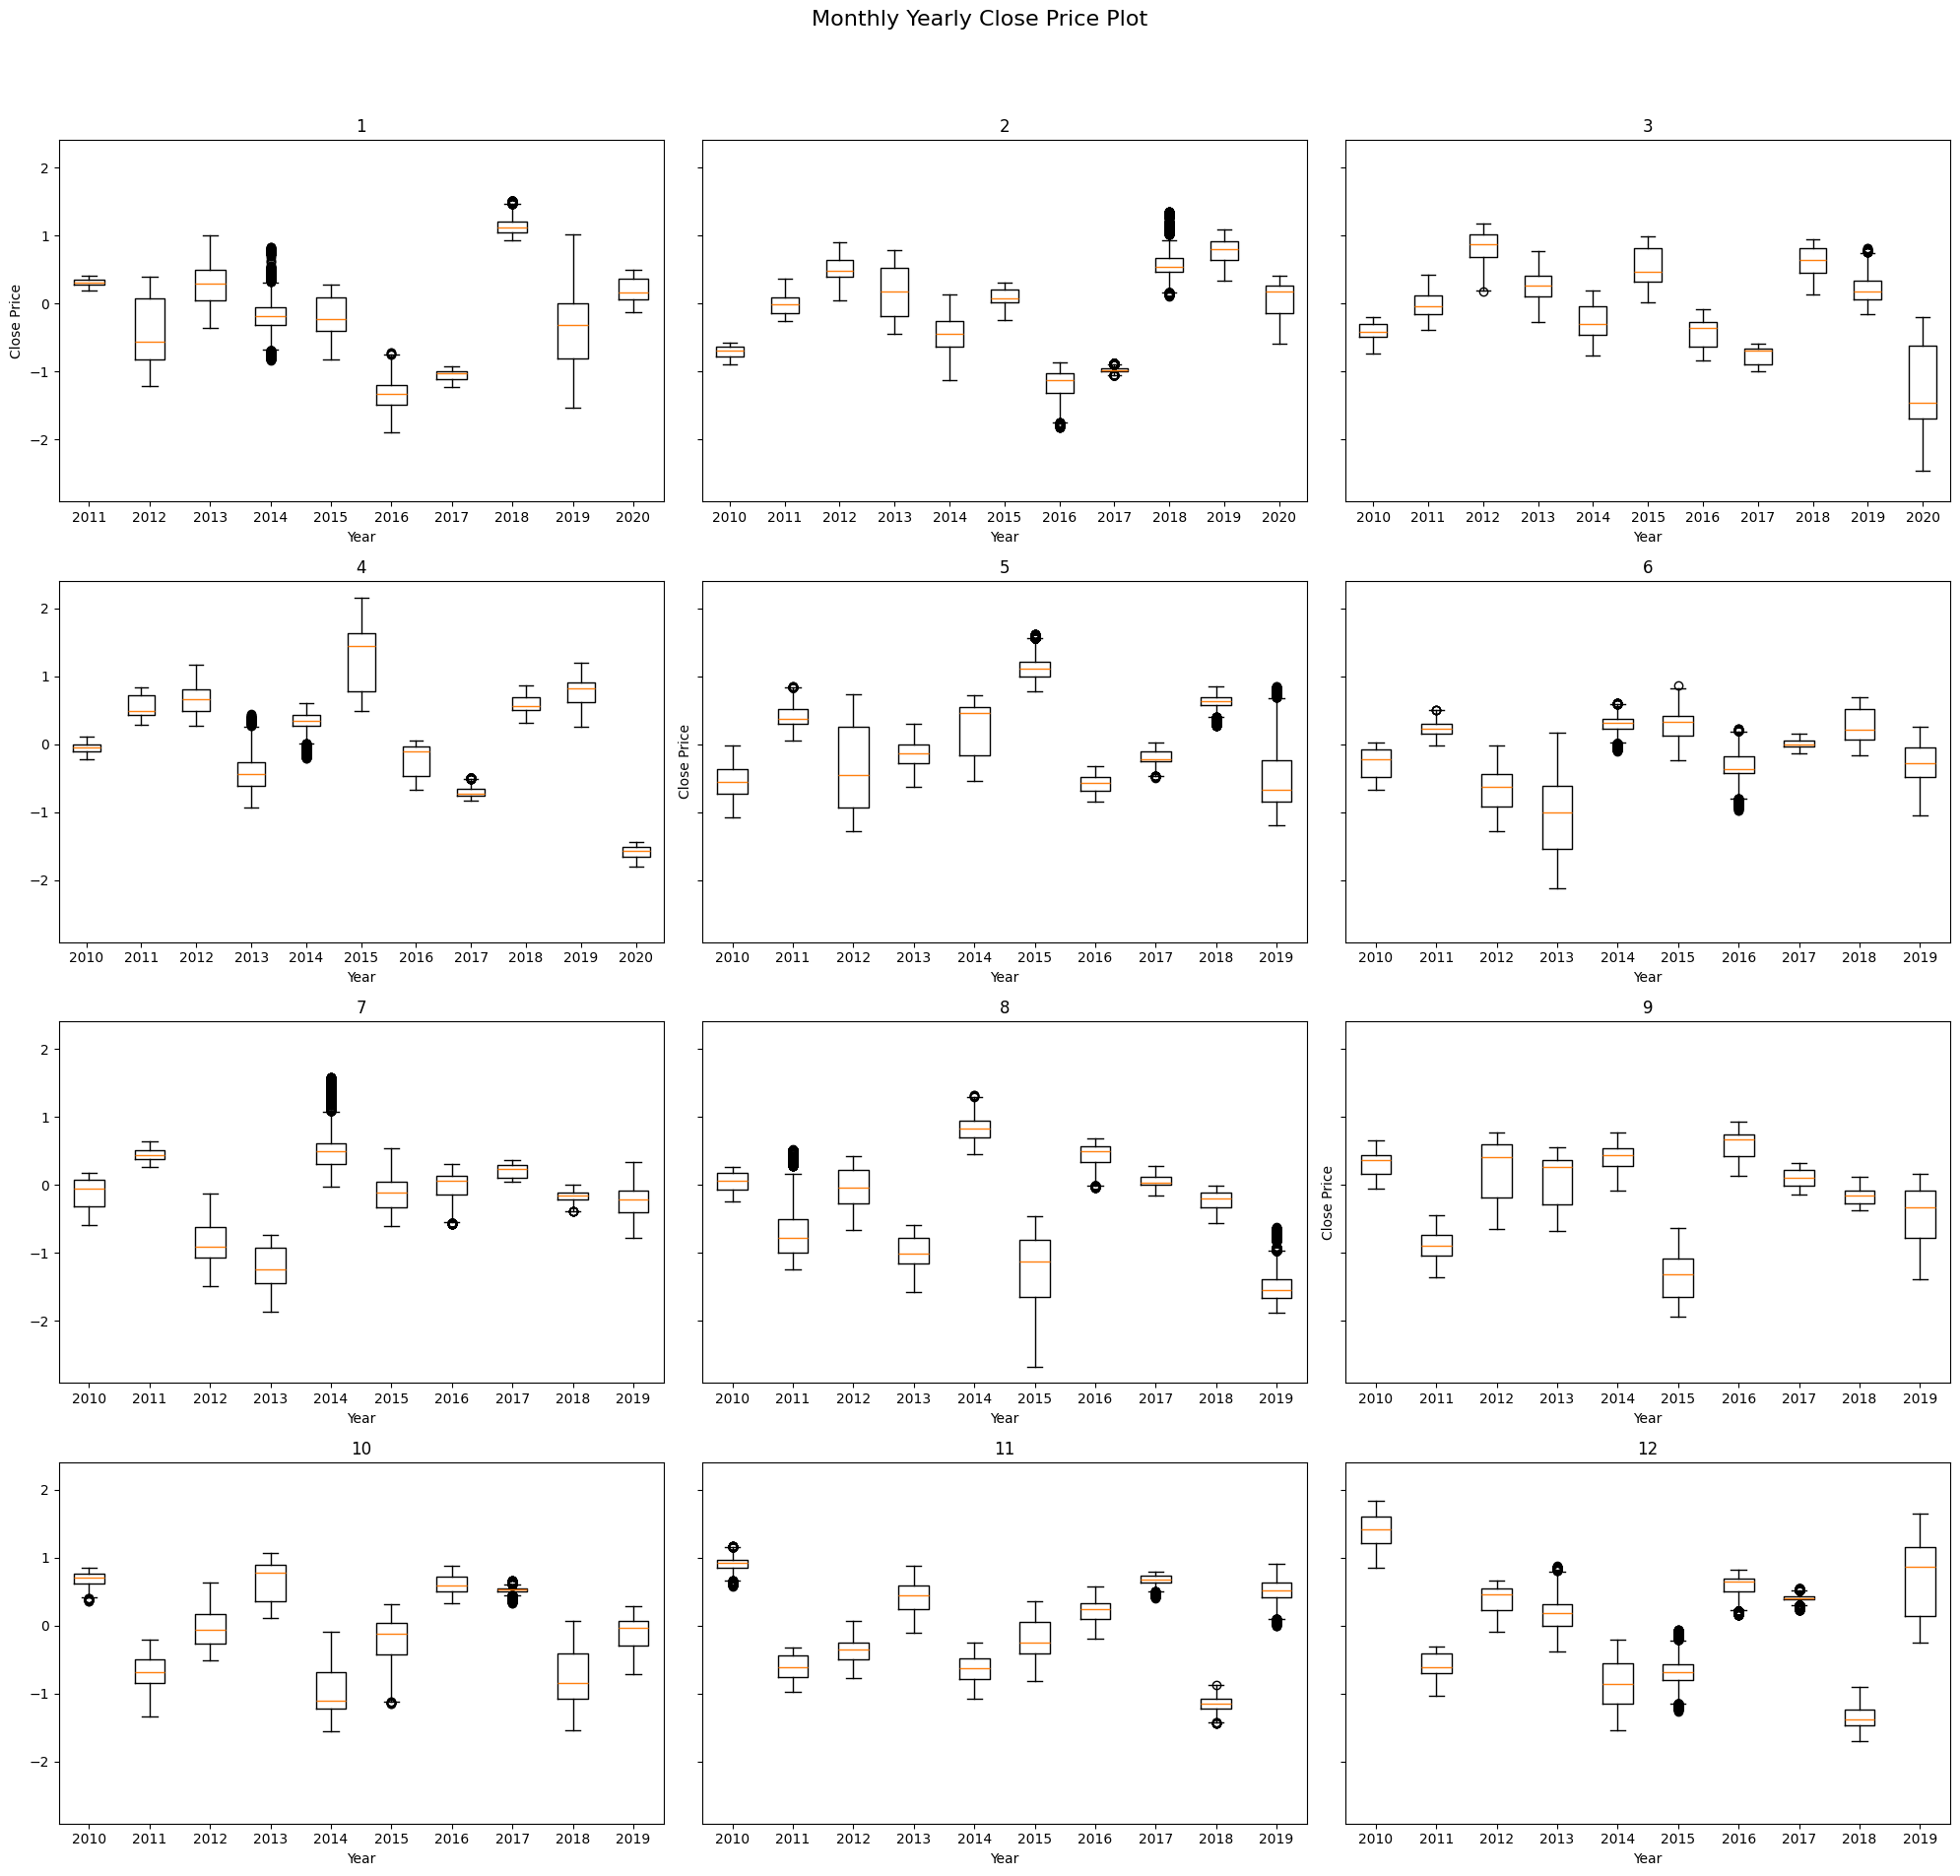

In [92]:
print("original")
plot_mycp(df)
print("z_scaled_by_year")
plot_mycp(z_scaled_by_year)
print("mm_scaled_by_year")
plot_mycp(mm_scaled_by_year)
print("r_scaled_by_year")
plot_mycp(r_scaled_by_year)

#### plot_var_heatmap

In [ ]:
def plot_var_heatmap(df : pd.Series):
    # 월/연도 추출 (열은 만들지 않고 groupby에서 바로 처리)
    volatility = df.groupby([df.index.year, df.index.month]).std().unstack()

    # 인덱스를 연도로, 열을 월로 정리된 데이터프레임 (연도 × 월)
    plt.figure(figsize=(12, 8))
    sns.heatmap(volatility, cmap='YlOrRd', annot=True, fmt='.2f',
                linewidths=0.5, square=True, cbar_kws={'label': 'Std Dev of Close'})
    plt.title('Monthly Volatility (Standard Deviation of Close Price)')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.yticks(rotation=0)
    plt.show()

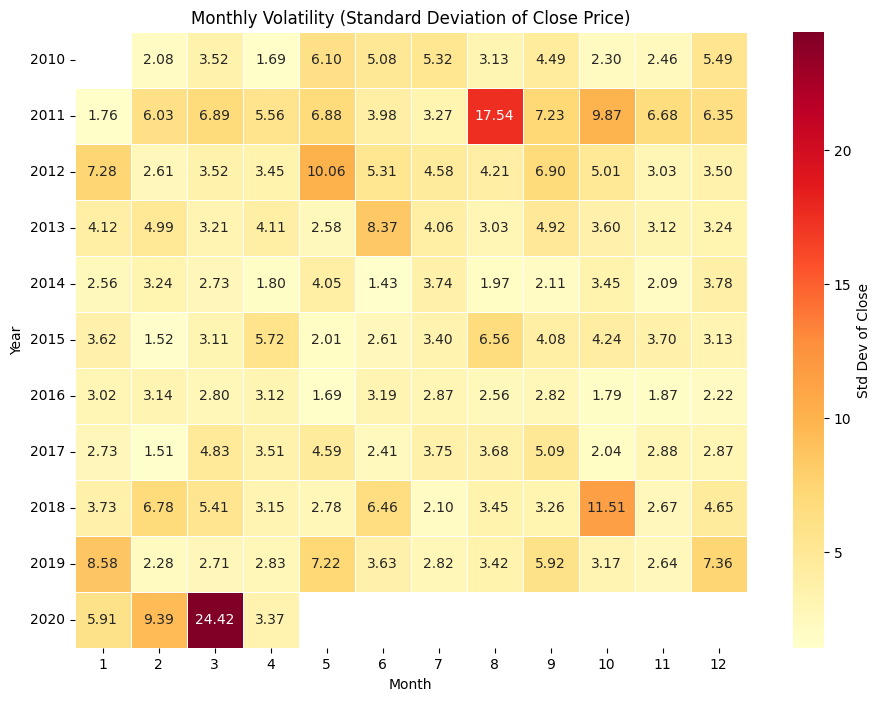

z_scaled_by_year


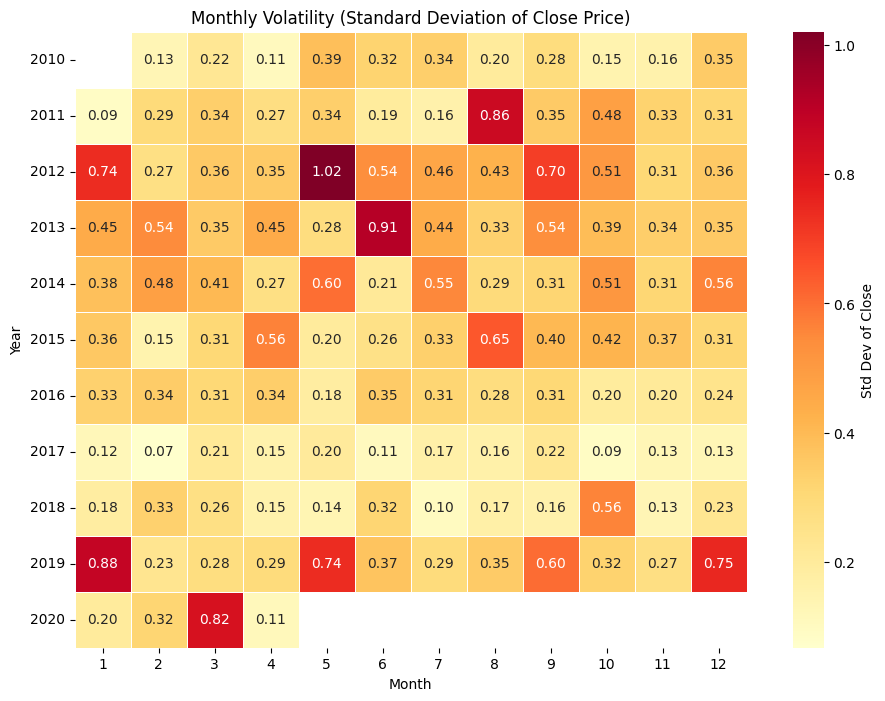

mm_scaled_by_year


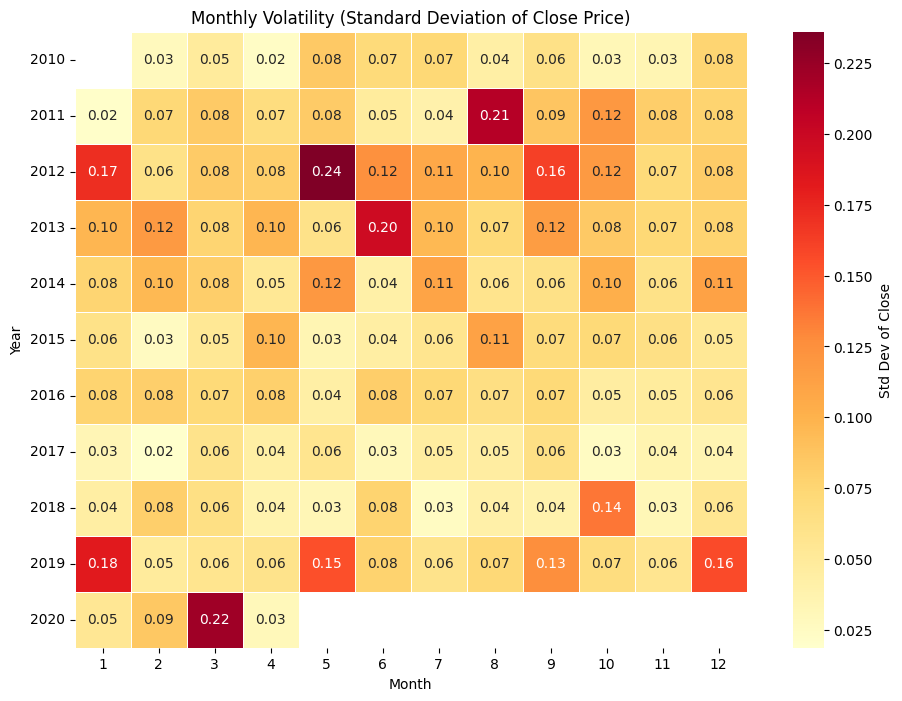

r_scaled_by_year


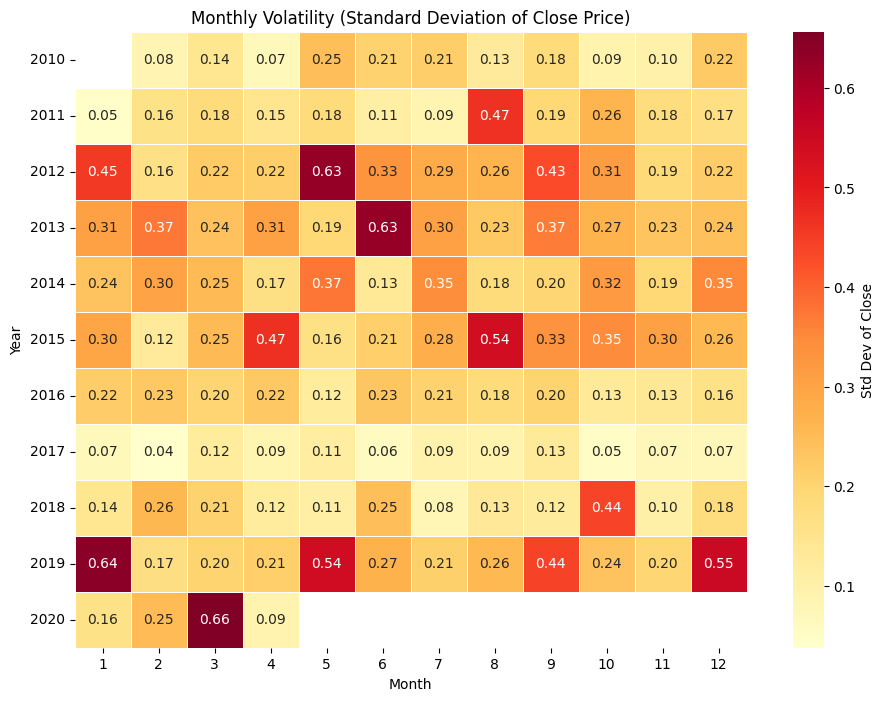

In [111]:
plot_var_heatmap(df['Close'])

print("z_scaled_by_year")
plot_var_heatmap(z_scaled_by_year['Close'])
print("mm_scaled_by_year")
plot_var_heatmap(mm_scaled_by_year['Close'])
print("r_scaled_by_year")
plot_var_heatmap(r_scaled_by_year['Close'])

### 요일별 비교

#### plot_weekly_cp

In [114]:
def plot_weekly_cp(df):
    """
    Weekly Close Price Plot by Year
    shape : (2, 3) for 5 weekdays
    """
    weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    _, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharey=True)
    axes = axes.flatten()

    for day in range(5):  # 0: Monday ~ 4: Friday
        daily_data = df[df.index.dayofweek == day]

        # 연도별로 그룹화해서 'Close'만 추출
        grouped = [group['Close'] for _, group in daily_data.groupby(daily_data.index.year)]
        years = sorted(daily_data.index.year.unique())

        axes[day].boxplot(grouped, tick_labels=years)
        axes[day].set_title(weekday_names[day])
        axes[day].set_xlabel('Year')
        if day in [0, 3]:  # 첫열에만 Y 라벨
            axes[day].set_ylabel('Close Price')

    # 빈 subplot 제거 (총 6칸 중 1칸 남음)
    fig = plt.gcf()
    fig.delaxes(axes[-1])

    plt.suptitle('Weekly Yearly Close Price Plot', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

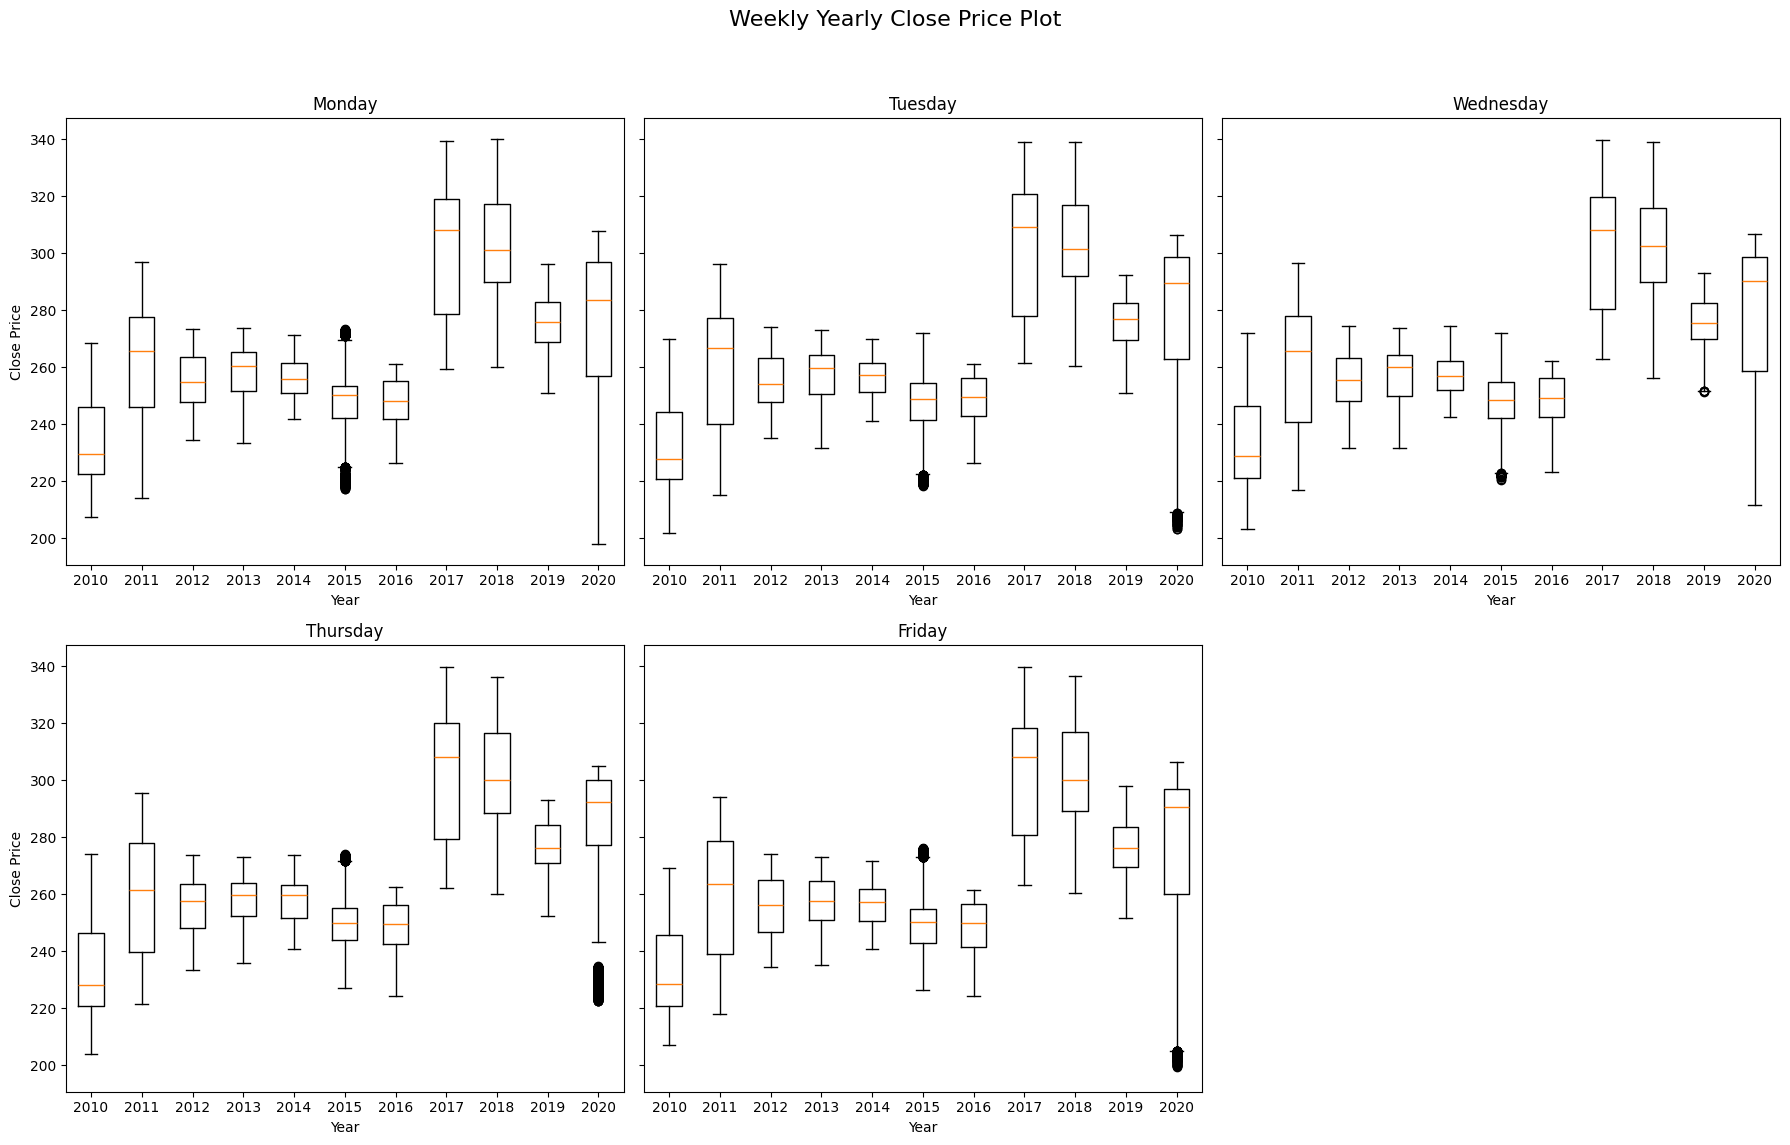

z_scaled_by_year


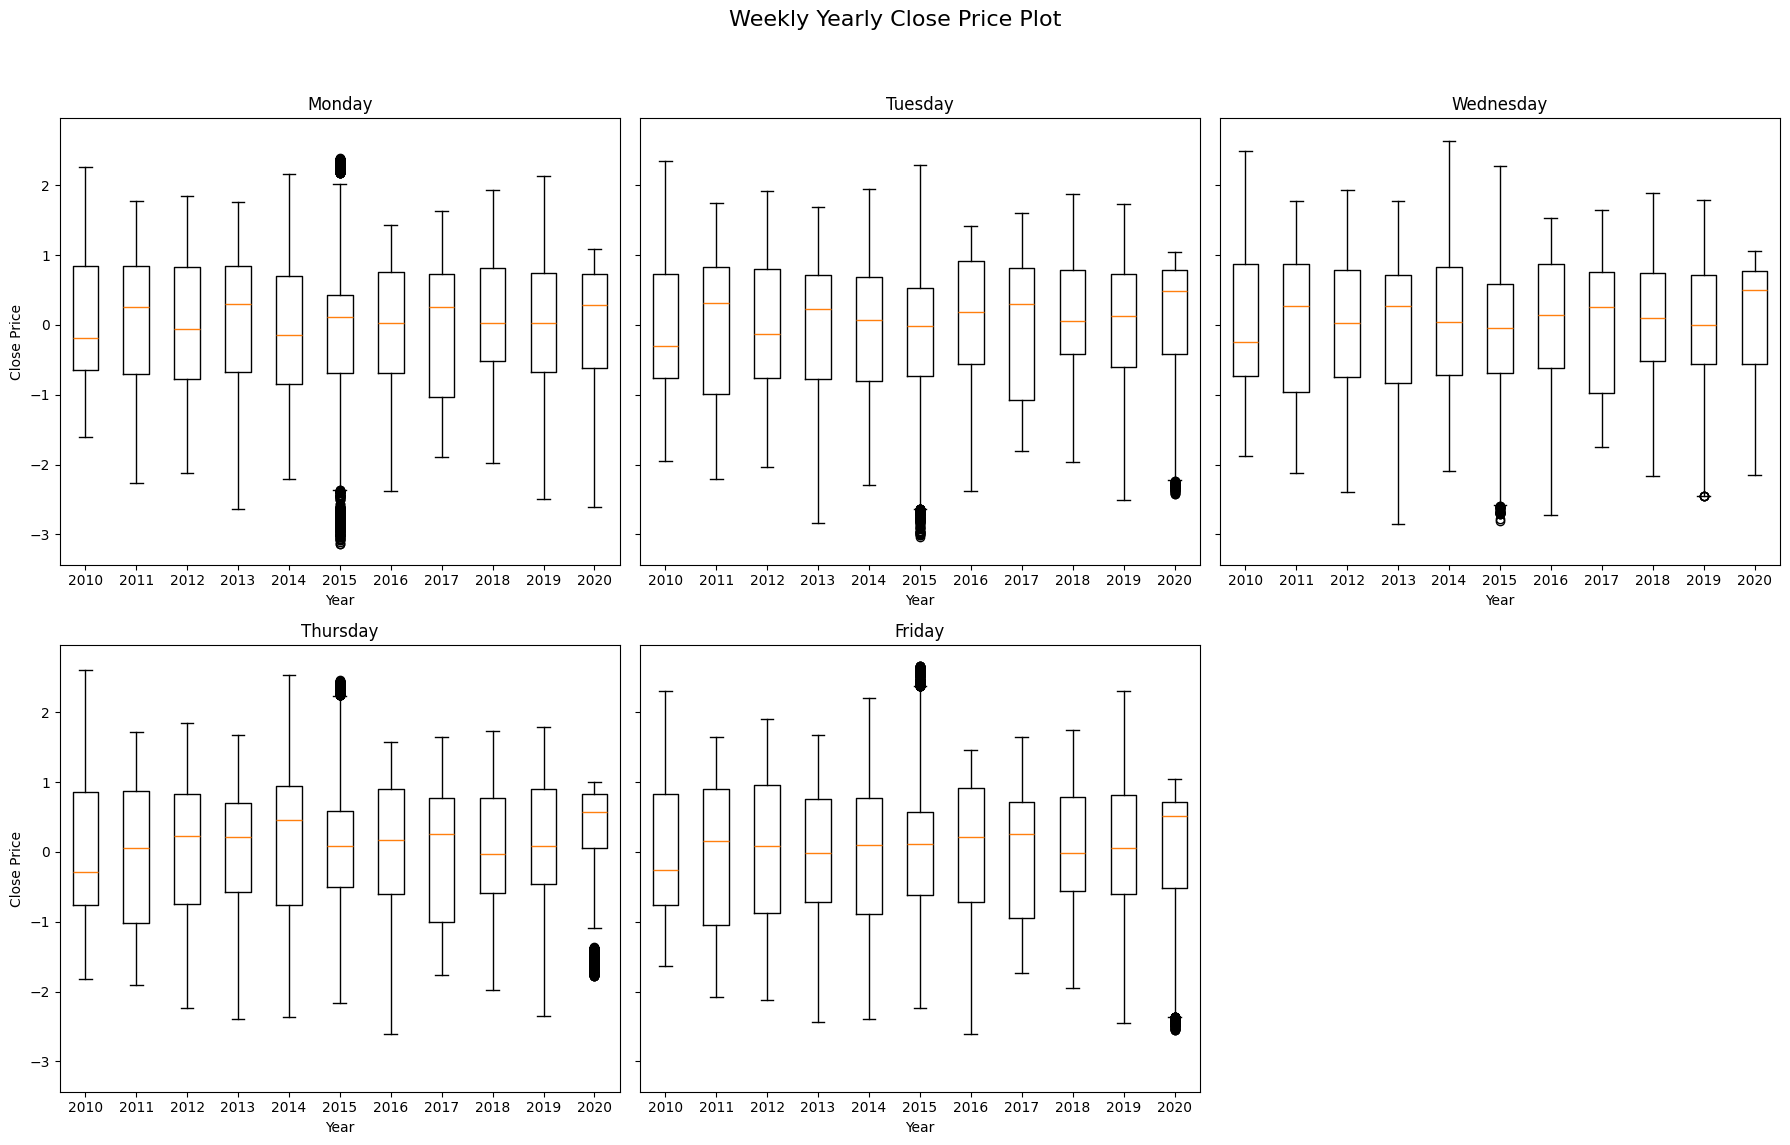

mm_scaled_by_year


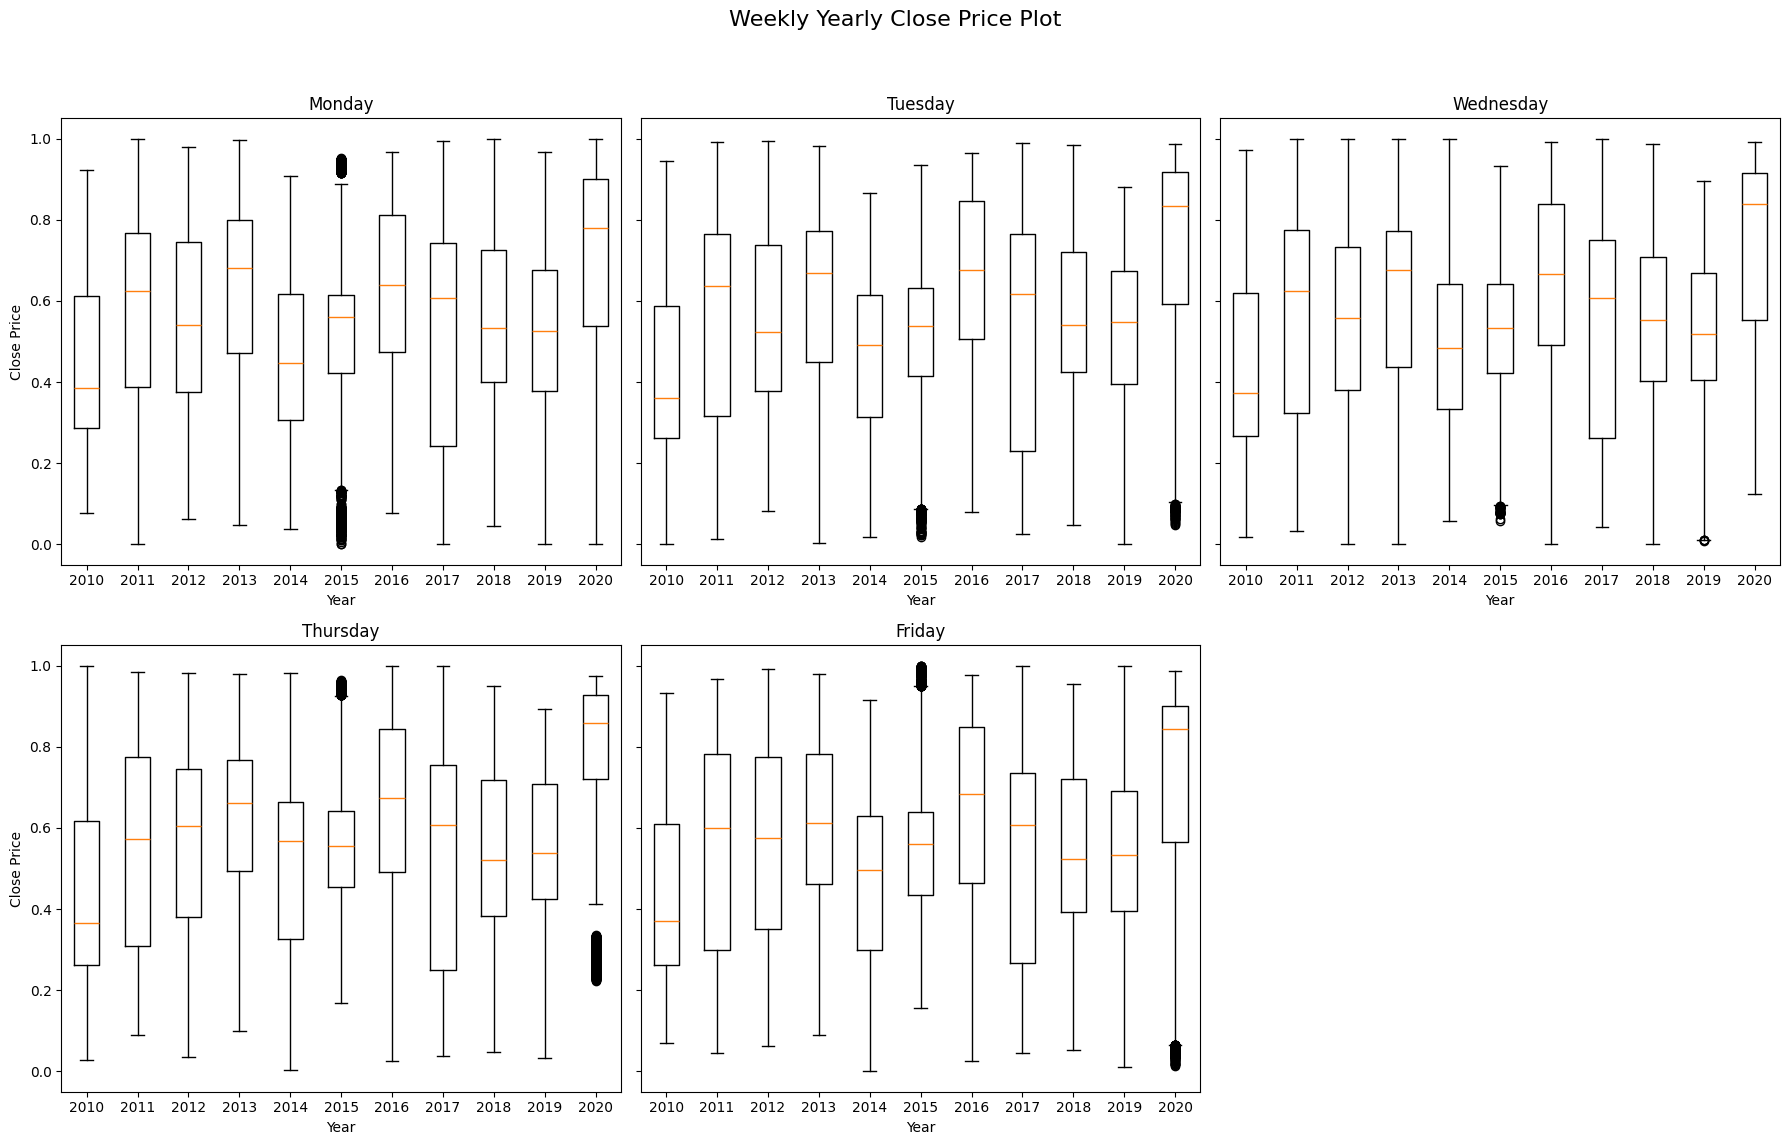

r_scaled_by_year


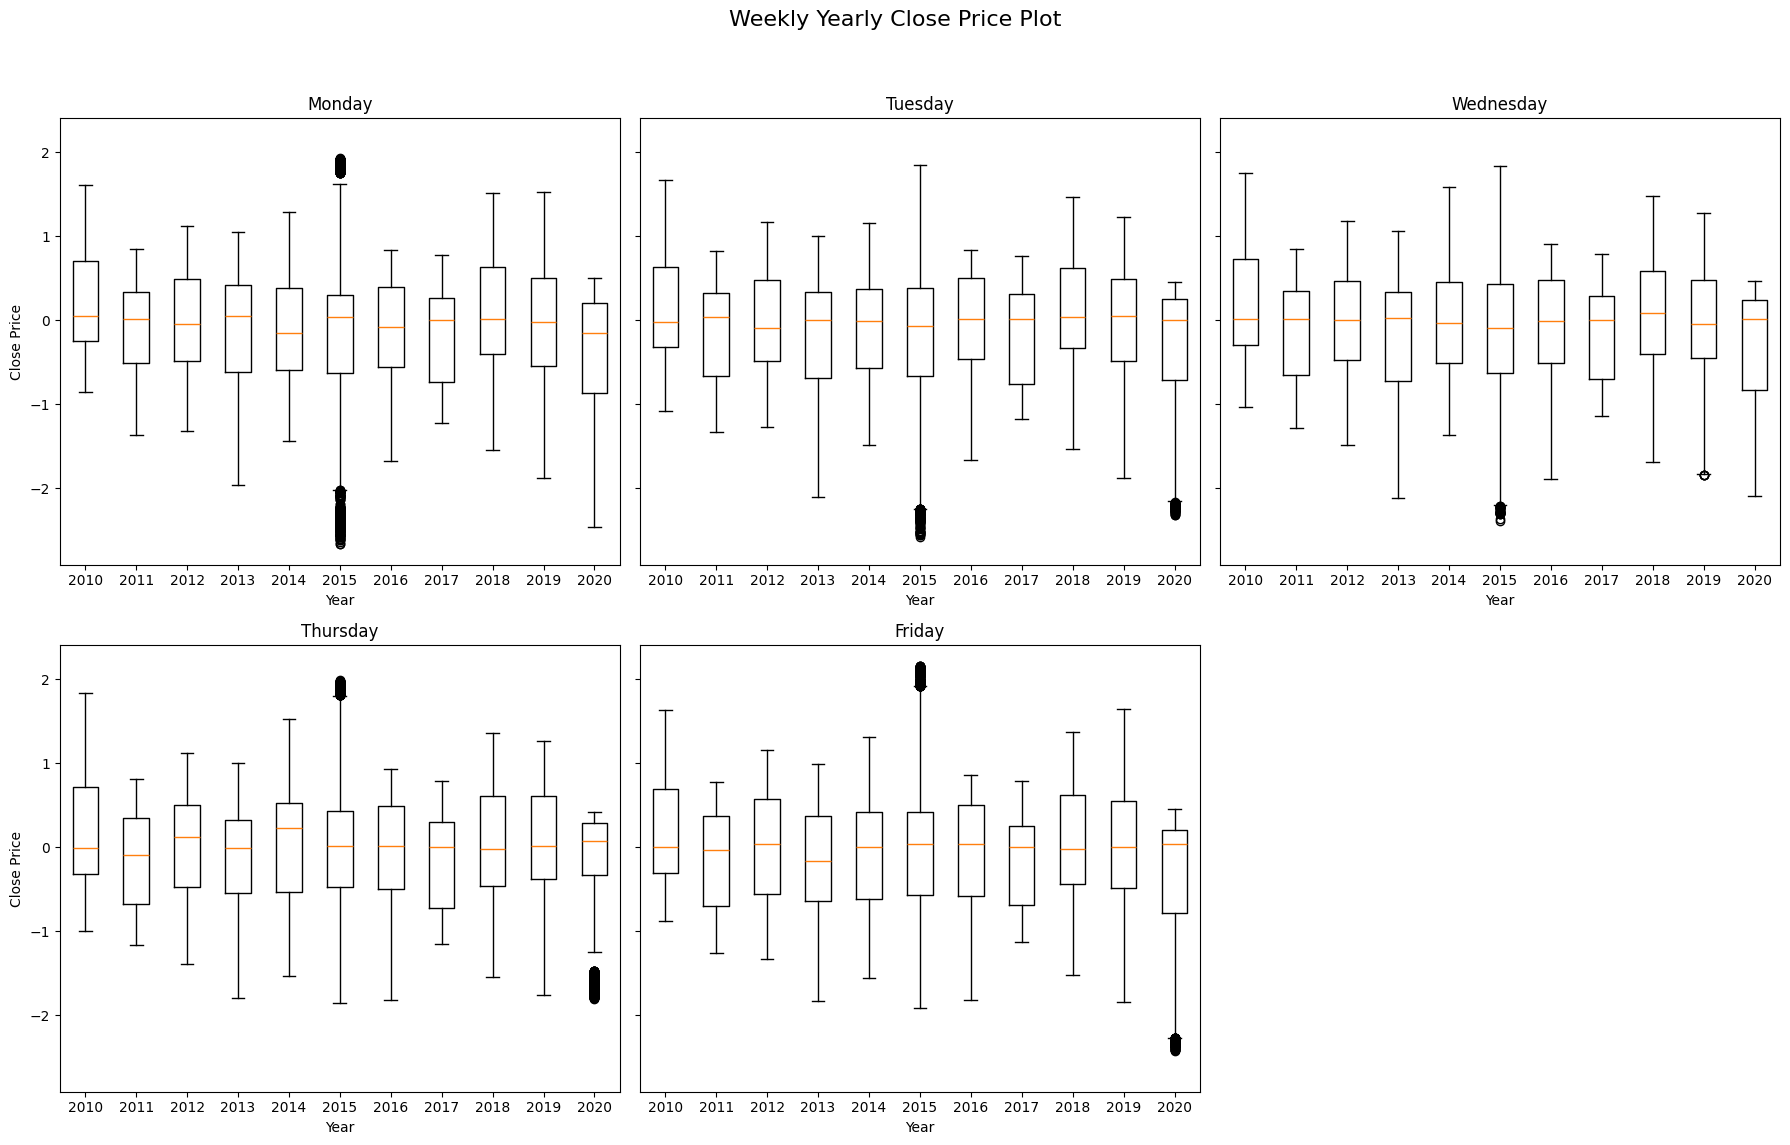

In [120]:
plot_weekly_cp(df)
print("z_scaled_by_year")
plot_weekly_cp(z_scaled_by_year)
print("mm_scaled_by_year")
plot_weekly_cp(mm_scaled_by_year)
print("r_scaled_by_year")
plot_weekly_cp(r_scaled_by_year)

## 파생 지표

In [13]:
df['Range'] = df['High'] - df['Low']
df['Momentum'] = df['Close'] - df['Open']
df['Return'] = (df['Close'] / df['Close'].shift(10) - 1)

In [14]:
df.head(3)

,Open,High,Low,Close,PrevClose,Volumn,Range,Momentum,Return
2010-02-16 09:01:00,207.55,207.65,207.50,207.60,207.5,3985.0,0.15,0.05,NaN
2010-02-16 09:02:00,207.60,207.65,207.25,207.55,207.5,5095.0,0.40,-0.05,NaN
2010-02-16 09:03:00,207.55,207.80,207.50,207.60,207.5,2175.0,0.30,0.05,NaN


<Axes: xlabel='Month', ylabel='Day'>

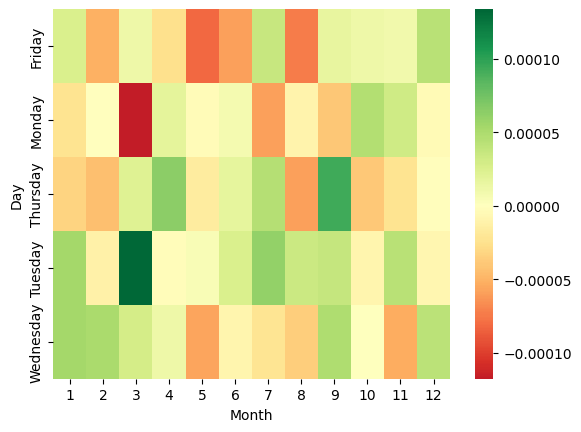

In [18]:
df['Day'] = df.index.day_name()
df['Month'] = df.index.month
pivot = df.pivot_table(index='Day', columns='Month', values='Return', aggfunc='mean')
sns.heatmap(pivot, cmap='RdYlGn', center=0)

### 거래량이랑 수익률

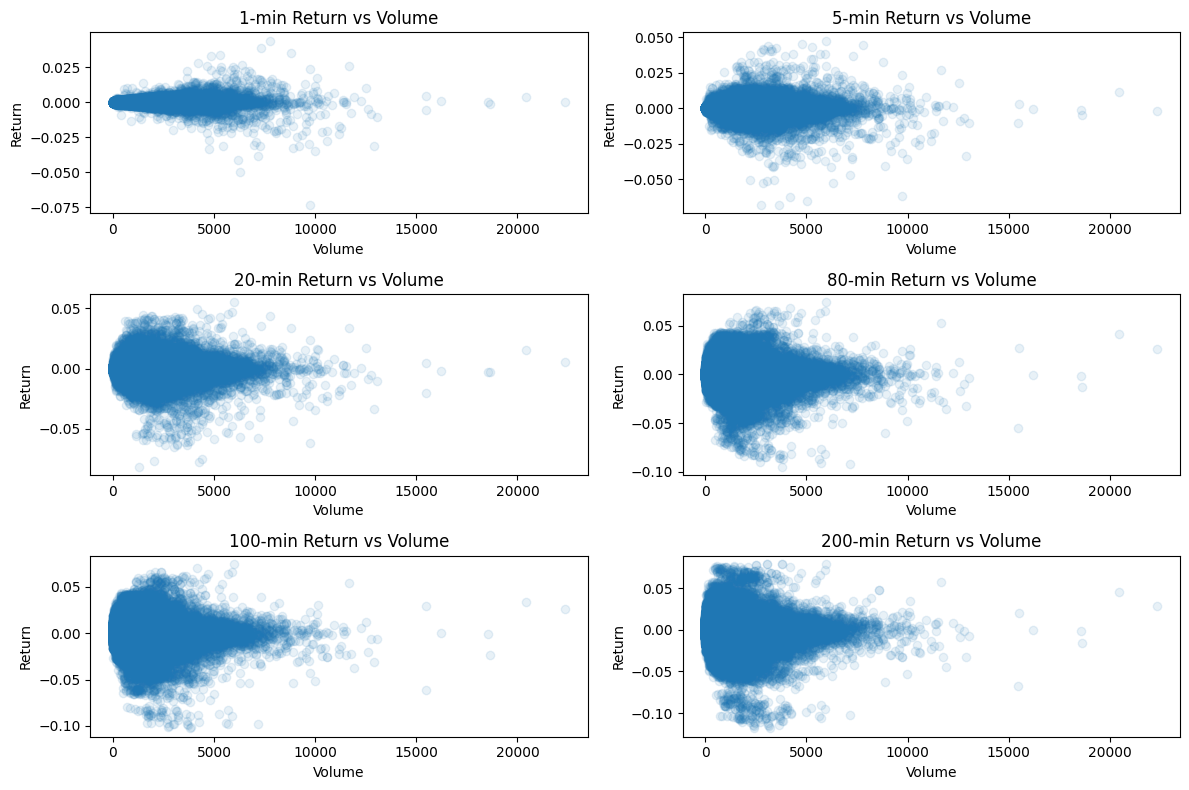

In [27]:
# 예시 periods 설정
periods_list = [1, 5, 20, 80, 100, 200]
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()

for i, period in enumerate(periods_list):
    returns = df['Close'].pct_change(periods=period)
    axes[i].scatter(df['Volumn'], returns, alpha=0.1)
    axes[i].set_title(f'{period}-min Return vs Volume')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel('Return')

plt.tight_layout()
plt.show()

### 수익률 

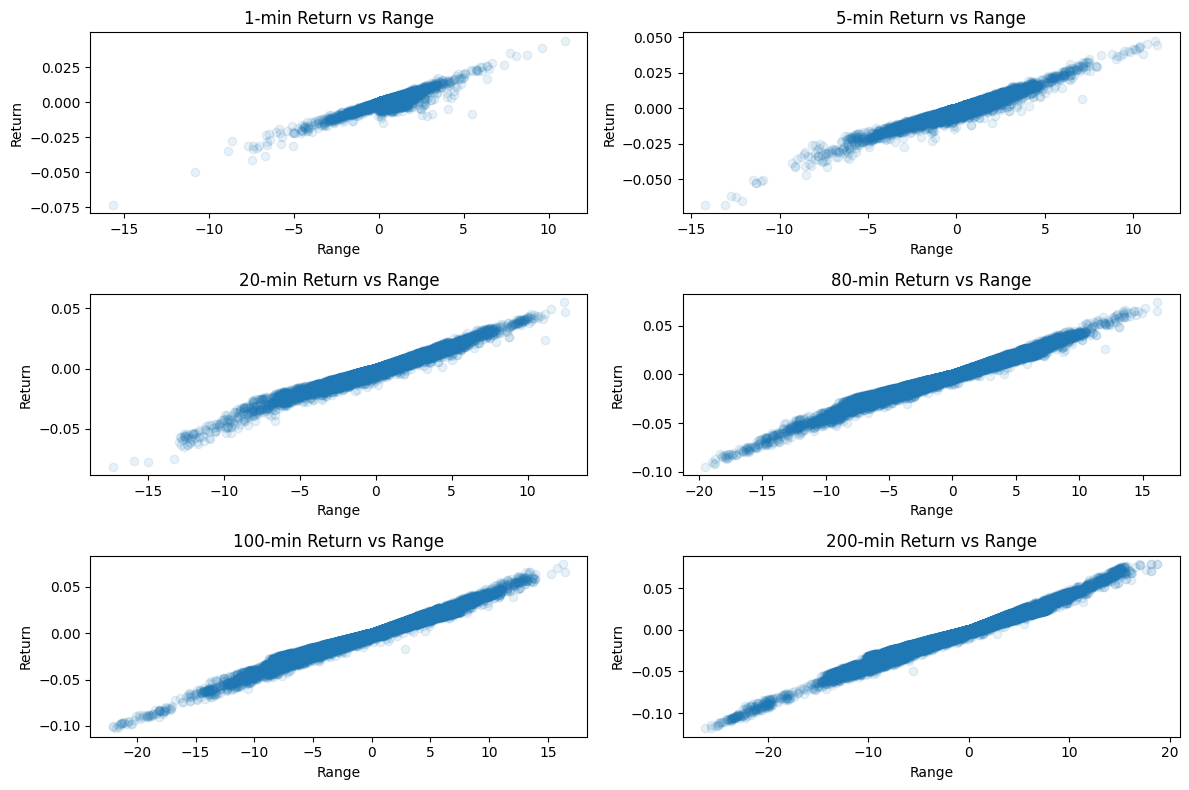

In [29]:
# 예시 periods 설정
# df['High'] - df['Low']
periods_list = [1, 5, 20, 80, 100, 200]
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()

for i, period in enumerate(periods_list):
    returns = df['Close'].pct_change(periods=period)
    axes[i].scatter(df['High'] - df['Low'].shift(period), returns, alpha=0.1)
    axes[i].set_title(f'{period}-min Return vs Range')
    axes[i].set_xlabel('Range')
    axes[i].set_ylabel('Return')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in h_df.groupby(h_df.index.year):
    group[['close']].plot(ax=ax, alpha=0.4)

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Hour)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [17]:
# df['ADX'] = ta.trend.adx(df['high'], df['low'], df['close'])
df.tail(1)

,open,high,low,close,prevClose,volumn,ADX
2020-04-03 15:45:00,231.65,231.65,231.65,231.65,231.65,6748.0,NaN
